In [1]:
import numpy as np
import pandas as pd
import scanpy.api as sc
import anndata
import bbknn
import matplotlib.pyplot as plt
import time
import os
import subprocess

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures
sc.logging.print_versions()

np.random.seed(0)

/Users/kp9/anaconda3/envs/orig/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


scanpy==1.2.2 anndata==0.6.4 numpy==1.14.2 scipy==1.0.1 pandas==0.22.0 scikit-learn==0.19.1 statsmodels==0.8.0 python-igraph==0.7.1 louvain==0.6.0 


Part two of the benchmarking, BBKNN versus Scanorama only, but more cells. Same setup as before, with the `experiment` and `scanorama` directories and all the Scanorama-specific scripts detailed in part one. Moving back to the 4-core, 16 GB RAM MacBook Pro as we're just testing the two quickest methods.

Move to a 10,000 gene space, as the remaining methods are fast and 10,000 is representative of what Scanorama would filter down to as its HVGs. Evaluate Scanorama and both BBKNN neighbour detection algorithms (the exact `cKDTree` and the approximate annoy) for datasets ranging from 2^11 (~2000) to 2^18 (~250,000) cells.

In [2]:
celltypeA = np.random.random((1,10000))**10
celltypeB = np.random.random((1,10000))**10

batch0 = np.random.normal(size=(1,10000),loc=1,scale=0.5)
batch1 = np.random.normal(size=(1,10000),loc=1,scale=0.5)
batch2 = np.random.normal(size=(1,10000),loc=1,scale=0.5)
batch3 = np.random.normal(size=(1,10000),loc=1,scale=0.5)

In [3]:
ckd_time = []
annoy_time = []
for N in np.arange(8,16):
    expr_template = np.vstack((np.tile(celltypeA,(2**N,1)),np.tile(celltypeB,(2**N,1))))
    exprs0 = (expr_template + np.random.normal(size=(2**(N+1),10000),scale=0.1)) * batch0
    exprs1 = (expr_template + np.random.normal(size=(2**(N+1),10000),scale=0.1)) * batch1
    exprs2 = (expr_template + np.random.normal(size=(2**(N+1),10000),scale=0.1)) * batch2
    exprs3 = (expr_template + np.random.normal(size=(2**(N+1),10000),scale=0.1)) * batch3
    del expr_template
    adata = anndata.AnnData(X=np.vstack((exprs0,exprs1,exprs2,exprs3)))
    del exprs0
    del exprs1
    del exprs2
    del exprs3
    adata.obs['celltype'] = np.tile(np.concatenate((np.repeat('A',2**N),np.repeat('B',2**N))),4)
    adata.obs['batch'] = [str(i) for i in np.repeat(np.arange(4),2**(N+1))]
    sc.tl.pca(adata)
    t1 = time.time()
    bbknn.bbknn(adata)
    t2 = time.time()
    ckd_time.append(t2-t1)
    t1 = time.time()
    bbknn.bbknn(adata,approx=True)
    t2 = time.time()
    annoy_time.append(t2-t1)

computing batch balanced neighbors
    finished (0:00:00.37) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing batch balanced neighbors
    finished (0:00:00.37) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing batch balanced neighbors
    finished (0:00:00.99) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing batch balanced neighbors
    finished (0:00:00.83) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing batch balanced neighbors
    finished (0:00:02.40) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing batch balanced neighbors
    finished (0:00:01.77) --> added to `

Scanorama is unable to process the 2^17 (~125,000) cell dataset and errors out due to resource constraints. As such, cut it off prematurely.

In [4]:
scanorama_time = []
os.chdir('../scanorama')
#this dies on N=14, so cut it early
for N in np.arange(8,14):
    expr_template = np.vstack((np.tile(celltypeA,(2**N,1)),np.tile(celltypeB,(2**N,1))))
    exprs0 = (expr_template + np.random.normal(size=(2**(N+1),10000),scale=0.1)) * batch0
    exprs1 = (expr_template + np.random.normal(size=(2**(N+1),10000),scale=0.1)) * batch1
    exprs2 = (expr_template + np.random.normal(size=(2**(N+1),10000),scale=0.1)) * batch2
    exprs3 = (expr_template + np.random.normal(size=(2**(N+1),10000),scale=0.1)) * batch3
    adata = anndata.AnnData(X=np.vstack((exprs0,exprs1,exprs2,exprs3)))
    del expr_template
    del exprs0
    del exprs1
    del exprs2
    del exprs3
    adata.obs['celltype'] = np.tile(np.concatenate((np.repeat('A',2**N),np.repeat('B',2**N))),4)
    adata.obs['batch'] = [str(i) for i in np.repeat(np.arange(4),2**(N+1))]
    for batch in [str(i) for i in np.arange(4)]:
        df=pd.DataFrame(data=adata[adata.obs['batch']==batch].X.transpose(),
                        index=adata[adata.obs['batch']==batch].var_names,
                        columns=np.arange(np.sum(adata.obs['batch']==batch)))
        df.to_csv('../scanorama/data/simul/'+batch+'.txt',sep='\t')
    del adata
    del df
    subprocess.run('python bin/process.py conf/simul.txt', shell=True)
    res = subprocess.run('python bin/simul.py', shell=True, stdout=subprocess.PIPE)
    scanorama_time.append(float(res.stdout.decode('utf-8').split('\n')[-2]))
    del res
    print(scanorama_time[-1])
os.chdir('../experiment')

6.490329027175903
12.587922811508179
20.409188747406006
41.73166608810425
91.19898700714111
274.81899905204773


As cell count goes up, `cKDTree` tapers off in performance, and would likely meet the near-linearly scaling Scanorama at or near the largest evaluated dataset size, i.e. ~250,000 cells. However, annoy scales linearly as well, and manages to retain an order of magnitude of performance difference between itself and Scanorama. Also, Scanorama runs into the aforementioned resource constraints and aborts at ~125,000 cells, while BBKNN's lightweight nature means it still processes a dataset twice that size without any issue.

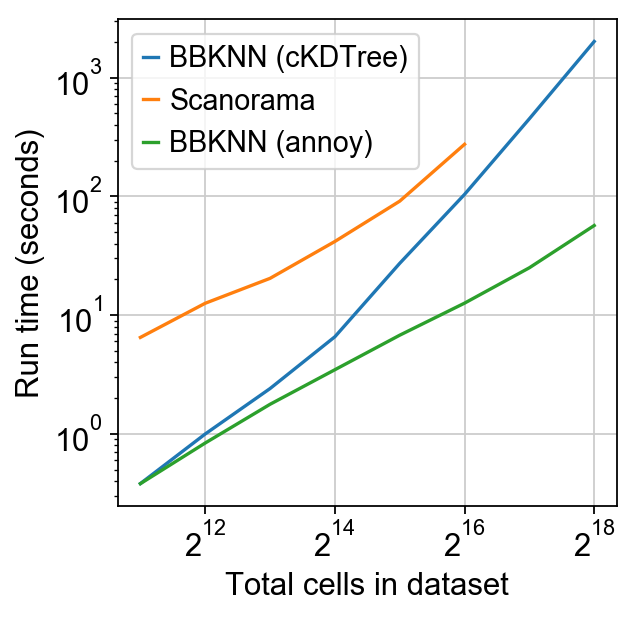

In [5]:
fig, ax = plt.subplots()
plt.plot(2**np.arange(11,19),ckd_time)
plt.plot(2**np.arange(11,17),scanorama_time)
plt.plot(2**np.arange(11,19),annoy_time)
ax.set_xscale('log', basex=2)
ax.set_yscale('log', basey=10)
plt.legend(['BBKNN (cKDTree)','Scanorama','BBKNN (annoy)'])
plt.xlabel('Total cells in dataset')
plt.ylabel('Run time (seconds)')

fig.savefig('bbknn_scanorama_10000genes.pdf',bbox_inches='tight')
plt.show()